In [99]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [100]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [101]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [102]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [103]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/jd/3mx9b7nj5hg_077gv13p6zt00000gn/T/ipykernel_67621/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [104]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [105]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [106]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [107]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


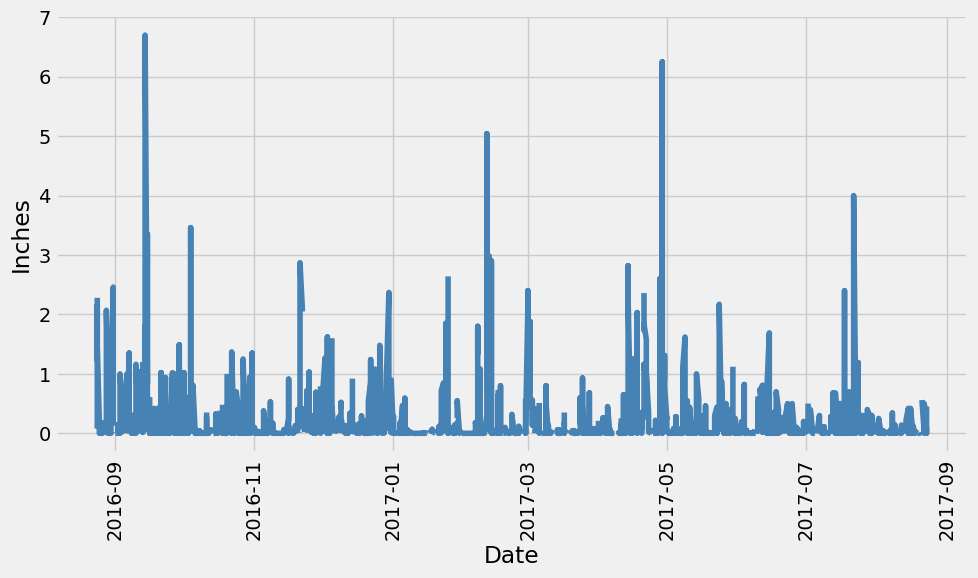

In [108]:
# Step 1: Find the most recent date in the dataset

most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Step 2: Calculate the date one year from the most recent date
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Step 3: Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= one_year_ago).\
        order_by(Measurement.date).all()

# Step 4: Save the query results as a Pandas DataFrame and explicitly set the column names
precipitation_df = pd.DataFrame(query, columns=['Date', 'Precipitation'])

# Step 5: Sort the DataFrame by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values('Date')

# Step 6: Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation', color='steelblue')

# Customize the plot

plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [109]:
# Use Pandas to calculate the summary statistics for the precipitation data


precipitation_summary = precipitation_df['Precipitation'].describe()

# Print the summary statistics
print(precipitation_summary)



count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [110]:
# Query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
total_stations


9

In [111]:
# Query to find the most active stations (stations with the most rows)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

# Output the results
for station, count in active_stations:
    print(f"{station}, {count}")


USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [113]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Query to find the most active station (already done in previous step)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

# Get the most active station (the first one in the list)
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),  # Minimum temperature
    func.max(Measurement.tobs),  # Maximum temperature
    func.avg(Measurement.tobs)   # Average temperature
).filter(Measurement.station == most_active_station).all()

# Output the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Most active station: {most_active_station}")
print(f"Lowest temperature: {min_temp}°F")
print(f"Highest temperature: {max_temp}°F")
print(f"Average temperature: {avg_temp:.2f}°F")


Most active station: USC00519281
Lowest temperature: 54.0°F
Highest temperature: 85.0°F
Average temperature: 71.66°F


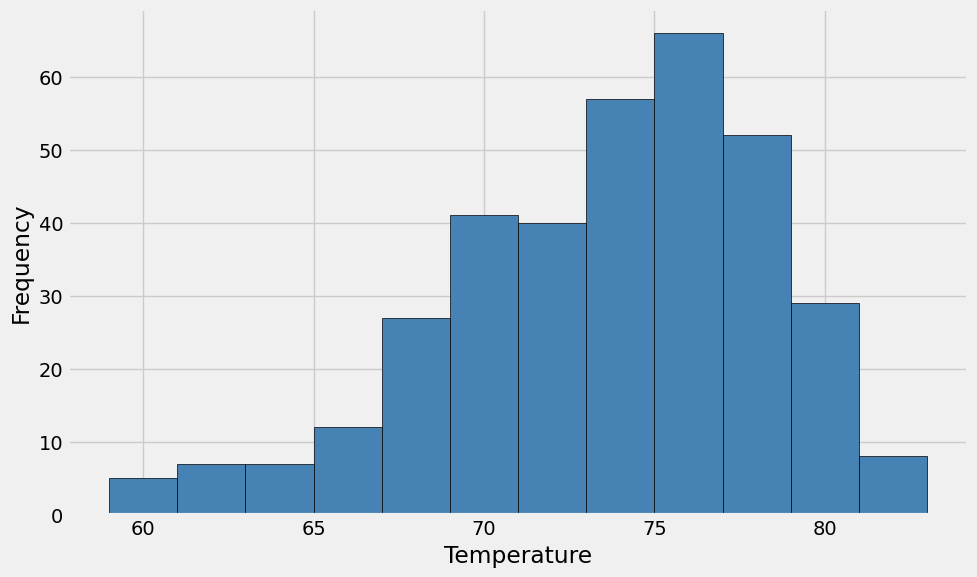

In [120]:


# Step 1: Get the most active station (already found in previous query)
most_active_station = active_stations[0][0]

# Step 2: Calculate the date one year ago from the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Step 3: Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date >= one_year_ago).\
                    order_by(Measurement.date).all()

# Convert the result to a Pandas DataFrame for easier manipulation
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Step 4: Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='steelblue', edgecolor='black')

# Customize the plot

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()

# Show the plot
plt.show()


# Close Session

In [121]:
# Close Session
session.close()